# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv1_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version:    2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [2]:
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/heatmap.html
import ipyleaflet as ipylft
from ipyleaflet import Map, Heatmap, LayersControl

In [3]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions


In [4]:
import scooby # Reports Python environment

In [5]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz','ipyleaflet']))


--------------------------------------------------------------------------------
  Date: Fri Oct 14 16:06:32 2022 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.5.0
          pyincore : 1.7.0
      pyincore_viz : Version unknown
        ipyleaflet : 0.17.1
             numpy : 1.23.3
             scipy : 1.9.1
           IPython : 8.5.0
        matplotlib : 3.6.0
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [6]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [7]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/

# NOTE on file path length. WINDOWS has a limit of 260 characters for file path length.
# Community name needs to be short to avoid this limit.

'''
communities = {'Mobile_AL' : {
                    'community_name' : 'Mobile, AL',
                    'STATE' : 'ALABAMA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '01097', 'Name' : 'Mobile County, AL'}}}}
'''


communities = {'SLC_UT' : {
                    'community_name' : 'Salt Lake City, UT',
                    'STATE' : 'UTAH',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '49035', 'Name' : 'Salt Lake City County, UT'}}}}

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [8]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0


In [9]:
# create data_service object for loading files
data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [10]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

Generating Housing Unit Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Salt Lake City, UT: 1
Dataset Housing Unit Inventory v2.0.0 data for Salt Lake City, UT already exists in IN-CORE
Dataset already exists in IN-CORE with filename hui_v2-0-0_SLC_UT_2010_rs1000.csv
Use dataset_id: 63487fd188a94f621d8fd4a0
Dataset already exists on IN-CORE, use dataset_id: 63487fd188a94f621d8fd4a0


In [11]:
# Housing Unit inventory
housing_unit_inv_id = hui_dataset_id
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63487fd188a94f621d8fd4a0\hui_v2-0-0_SLC_UT_2010_rs1000\hui_v2-0-0_SLC_UT_2010_rs1000.csv


In [12]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")

In [13]:
housing_unit_inv_df['huid'].describe()

count                   364210
unique                  364210
top       B490351001001006H001
freq                         1
Name: huid, dtype: object

## Read in Building Inventory

In [14]:
# Building inventory
bldg_inv_id = "62fea288f5438e1f8c515ef8" # SLC building inventory - Milad Roohi
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\62fea288f5438e1f8c515ef8\Salt Lake County All Building\Salt Lake County All Building.shp


In [15]:
bldg_inv_gdf = gpd.read_file(filename)
# Check CRS of building inventory
bldg_inv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
from pyproj import CRS
# Update CRS to EPSG:4326 if not already in that format
if bldg_inv_gdf.crs != CRS.from_epsg(4326):
    bldg_inv_gdf = bldg_inv_gdf.to_crs(epsg=4326)
    print("The CRS of the building inventory has been updated to EPSG:4326")
else:
    print("The CRS of the building inventory is already in EPSG:4326")

The CRS of the building inventory is already in EPSG:4326


In [17]:
# Check Unique ID
bldg_inv_gdf[['guid','bldg_id']].astype(str).describe().T

,count,unique,top,freq
guid,284925,284925,6f8c3468-4696-4371-bc91-3a7ceec1e768,1
bldg_id,284925,112,16200000000000.0,17249


In [18]:
bldg_inv_gdf.head(1).T

,0
parid,28200000000000.0
parid_card,28200000000000.0
bldg_id,28200000000000.0
struct_typ,RM1L
archetype,COM3
str_prob,None
year_built,1993
no_stories,1
a_stories,None
b_stories,None


In [19]:
# What variable has information to determine if building is residential or not?
# County observations by variable
bldg_inv_gdf[['archetype','occ_type','guid']].groupby(['archetype','occ_type']).count()

,,guid
archetype,occ_type,
AGR1,AGR1,57
COM1,COM1,7900
COM10,COM10,373
COM2,COM2,4674
COM3,COM3,2096
COM4,COM4,5674
COM5,COM5,270
COM6,COM6,217
COM7,COM7,421


#### HAZUS Occupancy Status
Table 3-1: Hazus Occupancy Class Definitions

| Label             | Hazus Occupancy Class            |
|-------------------|----------------------------------|
|                   | Residential                      |
| RES1              | Single Family Dwelling           |
| RES2              | Mobile / Manufactured Home       |
| RES3A            | RES3A Duplex                      |
| RES3B            | RES3B 3-4 Units                   |
| RES3C  |  5-9 Units                 |
| RES3D  |  10-19 Units                         |
| RES3E  |   20-49 Units                      |
| RES3F |   50+ Units                       |
| RES4              | Temporary Lodging                |
| RES5              | Institutional Dormitory          |
| RES6              | Nursing Home                     |
|-------|------------------------------------|
|                   | Commercial                       |
| COM1              | Retail Trade                     |
| COM2              | Wholesale Trade                  |
| COM3              | Personal and Repair Services     |
| COM4              | Professional/Technical Services  |
| COM5  | Banks                              |
| COM6  | Hospital                           |
| COM7  | Medical Office/Clinic              |
| COM8  | Entertainment & Recreation         |
| COM9  | Theaters                           |
| COM10 | Parking                            |
|------|------------------------|
|       | Industrial                         |
|------|------------------------|
| IND1  | Heavy                              |
| IND2  | Light                              |
| IND3  | Food/Drugs/Chemicals               |
| IND4  | Metals/Minerals Processing         |
| IND5  | High Technology                    |
| IND6  | Construction                       |
|------|------------------------|
|       | Agriculture                        |
|------|------------------------|
| AGR1  | Agriculture                        |
|       | Religion/Membership Organizations  |
| REL1  | Church/Nonprofit                   |
|------|------------------------|
|       | Government                         |
|------|------------------------|
| GOV1  | General Services                   |
| GOV2  | Emergency Response                 |
|------|------------------------|
|      | Education              |
|------|------------------------|
| EDU1 | Grade School, Library  |
| EDU2 | College/University     |


### Find Spatial Extent of Building Inventory
Need to know which counties are included in the building inventory.

In [20]:
#map = viz.plot_gdf_map(bldg_inv_gdf,column='dlevel')
#map

#### Use Tract ID to find county FIPS code
The first 5 digits of the tract ID are the FIPS code for the county.

In [21]:
bldg_inv_gdf['tract_id'].describe()

count    2.849250e+05
mean     4.903511e+10
std      4.125693e+03
min      4.903510e+10
25%      4.903511e+10
50%      4.903511e+10
75%      4.903511e+10
max      4.903511e+10
Name: tract_id, dtype: float64

In [22]:
# Substring of tractid to get county 5 digit fips code 
# covert tract_id to string with leading zeros
bldg_inv_gdf['tract_id_str'] = bldg_inv_gdf['tract_id'].astype(str).str.zfill(11)
bldg_inv_gdf['county'] = bldg_inv_gdf['tract_id_str'].str[:5]
bldg_inv_gdf[['tract_id_str','county']].describe()

,tract_id_str,county
count,284925,284925
unique,193,1
top,49035113104,49035
freq,8331,284925


### Building Inventory File has 1 county
The Salt Late City building inventory only has 1 county.

## Generate Address Point Inventory


In [23]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

# HAZUS Archetypes for residential buildings include an estimate of housing units
HAZUS_residential_archetypes = { 
    "RES1" : {'Description' : "Single Family Dwelling", 'HU estimate' : 1},
    "RES2" : {'Description' : "Mobile / Manufactured Home", 'HU estimate' : 1},
    "RES3A" : {'Description' : "Duplex", 'HU estimate' : 2},
    "RES3B" : {'Description' : "3-4 Units", 'HU estimate' : 3},
    "RES3C" : {'Description' : "5-9 Units", 'HU estimate' : 7},
    "RES3D" : {'Description' : "10-19 Units", 'HU estimate' : 15},
    "RES3E" : {'Description' : "20-49 Units", 'HU estimate' : 30},
    "RES3F" : {'Description' : "50+ Units", 'HU estimate' : 50},
    "RES4" : {'Description' : "Temporary Lodging", 'HU estimate' : 1},
    "RES5" : {'Description' : "Institutional Dormitory", 'HU estimate' : 1},
    "RES6" : {'Description' : "Nursing Home", 'HU estimate' : 1}
    }

residential_archetypes = HAZUS_residential_archetypes 

In [24]:
for community in communities.keys():
    print("Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        archetype_var = 'archetype',
                        building_area_var = 'sq_foot',
                        building_area_cutoff = 300,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

Address point inventory for: SLC_UT
Based on building inventory: 62fea288f5438e1f8c515ef8
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for SLC_UT 2010
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Address Point Inventory v2.0.0 data for SLC_UT 2010: 1
Dataset Address Point Inventory v2.0.0 data for SLC_UT 2010 already exists in IN-CORE
Dataset already exists in IN-CORE with filename addpt_v2-0-0_SLC_UT_2010_62fea288f5438e1f8c515ef8.csv
Use dataset_id: 63497ce4b2332d481c436c09
Dataset already exists on IN-CORE, use dataset_id: 63497ce4b2332d481c436c09


### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [25]:
# Check if addpt_dataset_id is string
if isinstance(addpt_dataset_id, str):
    print("The Address Point Inventory ID is a pandas string")
    # Address Point inventory
    addpt_inv_id = addpt_dataset_id
    # load housing unit inventory as pandas dataframe
    addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
    filename = addpt_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
    addpt_inv_df = pd.read_csv(filename, header="infer")
# else if addpt_dataset_id is a dataframe
elif isinstance(addpt_dataset_id, pd.DataFrame):
    addpt_inv_df = addpt_dataset_id
    print("The Address Point Inventory ID contains a pandas dataframe")
else:
    print("The Address Point Inventory is not a string or pandas dataframe")

The Address Point Inventory ID is a pandas string
The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63497ce4b2332d481c436c09\addpt_v2-0-0_SLC_UT_2010_62fea288f5438e1f8c515ef8\addpt_v2-0-0_SLC_UT_2010_62fea288f5438e1f8c515ef8.csv


In [26]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                             502643
unique                                            502643
top       STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000
freq                                                   1
Name: addrptid, dtype: object

## Step 2: Housing Unit Allocation v2

### Setup Housing Unit Allocation

### Run Housing Unit Allocation

In [27]:
for community in communities.keys():
    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_gdf = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

Housing Unit Allocation for: SLC_UT
Based on housing unit inventory: 63487fd188a94f621d8fd4a0
Based on building inventory: 62fea288f5438e1f8c515ef8
Running up Housing Unit Allocation for SLC_UT
The file already exists: c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data/OutputData/SLC_UT/hua_v2-0-0_SLC_UT_2010_rs1000.csv


c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data\pyncoda\ncoda_07d_run_hua_workflow.py:426: DtypeWarning: Columns (0,17,24,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  huav2_df = pd.read_csv(csv_filepath)


Converting geometry to Geodataframe


## Explore and Validate Housing Unit Allocation


In [28]:
hua_gdf.head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,placeNAME10,x,y,archetype,geometry
0,B490351001001006H001,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,ST30ef8530-dfda-46ef-96c8-17e8fced0537AP000000,30ef8530-dfda-46ef-96c8-17e8fced0537,1.0,1.0,Salt Lake City,-111.917033,40.804688,RES5,POINT (-111.91703 40.80469)
1,B490351001001006H002,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000001,e176ee84-c869-47fe-a825-9854d9cb2bca,15.0,2.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)
2,B490351001001006H003,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000002,e176ee84-c869-47fe-a825-9854d9cb2bca,15.0,3.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)
3,B490351001001006H005,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,2.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000003,e176ee84-c869-47fe-a825-9854d9cb2bca,15.0,4.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)
4,B490351001001006H006,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,2.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000005,e176ee84-c869-47fe-a825-9854d9cb2bca,15.0,6.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)


In [29]:
hua_gdf.head(1).T

,0
huid,B490351001001006H001
Block2010,490351001001006
blockid,490351001001006.0
bgid,490351001001.0
tractid,49035100100.0
FIPScounty,49035.0
numprec,1.0
ownershp,2.0
race,1.0
hispan,0.0


In [30]:
# describe the housing unit allocation primary keys and foreign keys
hua_gdf[['huid','Block2010','addrptid','guid','strctid']].astype(str).describe().T

,count,unique,top,freq
huid,394422,364211,nan,30212
Block2010,394422,11631,999999999999999,30212
addrptid,394422,364211,nan,30212
guid,394422,284926,nan,20524
strctid,394422,255375,nan,30212


## Merge Housing Unit Allocation with Housing Unit Inventory

In [31]:
housing_unit_inv_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,vacancy,gqtype,incomegroup,hhinc,randincome,poverty
0,B490351001001006H001,490351001001006,490351001001,49035100100,49035,1,2.0,1.0,0.0,0.0,0,0,12,4,84651.0,0.0
1,B490351001001006H002,490351001001006,490351001001,49035100100,49035,1,2.0,1.0,0.0,0.0,0,0,8,3,44695.0,0.0
2,B490351001001006H003,490351001001006,490351001001,49035100100,49035,1,2.0,1.0,0.0,0.0,0,0,10,3,56215.0,0.0
3,B490351001001006H004,490351001001006,490351001001,49035100100,49035,1,2.0,1.0,0.0,0.0,0,0,14,5,128776.0,0.0
4,B490351001001006H005,490351001001006,490351001001,49035100100,49035,1,2.0,1.0,0.0,0.0,0,0,7,3,37398.0,0.0


In [32]:
housing_unit_inv_df[['huid','blockid']].astype(str).describe()

,huid,blockid
count,364210,364210
unique,364210,11630
top,B490351001001006H001,490351011021001
freq,1,667


In [33]:
# Merge HUA with HUI
hua_cols = ['huid','guid','placeNAME10','huestimate','x','y']
hua_hui_df = pd.merge(left = housing_unit_inv_df,
                       right = hua_gdf[hua_cols],
                       on='huid',
                       how='left')

In [34]:
hua_hui_df[['huid','blockid','guid']].astype(str).describe()

,huid,blockid,guid
count,364210,364210,364210
unique,364210,11630,254714
top,B490351001001006H001,490351011021001,nan
freq,1,667,20524


In [35]:
# Replace missing guid 
hua_hui_df['guid'] = hua_hui_df['guid'].fillna('missing building id')

In [36]:
hua_hui_df[['huid','blockid','guid']].astype(str).describe()

,huid,blockid,guid
count,364210,364210,364210
unique,364210,11630,254714
top,B490351001001006H001,490351011021001,missing building id
freq,1,667,20524


## Save Housing Unit Allocation to CSV and Upload to IN-CORE Dataservice

In [37]:
# save hua_hui_gdf to csv
check_folder = outputfolder
output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}_{bldg_inv_id}'
csv_filepath = check_folder+"/"+output_filename+'.csv'
savefile = sys.path[0]+"/"+csv_filepath
# Resave results for community name
hua_hui_df.to_csv(savefile, index=False)

In [38]:
# make a county list for community
county_list = ''
for county in communities[community]['counties'].keys():
    state_county = communities[community]['counties'][county]['FIPS Code']
    state_county_name  = communities[community]['counties'][county]['Name']
    print(state_county_name,': county FIPS Code',state_county)
    county_list = county_list + state_county_name+': county FIPS Code '+state_county
county_list

Salt Lake City County, UT : county FIPS Code 49035


'Salt Lake City County, UT: county FIPS Code 49035'

In [39]:
title = "Housing Unit Allocation v2.0.0 data for "+community + " " + str(basevintage)
title

'Housing Unit Allocation v2.0.0 data for SLC_UT 2010'

In [40]:
run_hua_gdf.upload_hua_file_to_incore(title =title,
                        county_list = county_list,
                        csv_filepath = csv_filepath,
                        output_filename = output_filename)

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
dataset is created with id 6349cfb888a94f621d8fd5dd
The file(s): hua_v2-0-0_SLC_UT_2010_rs1000_62fea288f5438e1f8c515ef8 have been uploaded to IN-CORE
Dataset now on IN-CORE, use dataset_id: 6349cfb888a94f621d8fd5dd
Dataset is only in personal account, contact IN-CORE to make public


'6349cfb888a94f621d8fd5dd'

### Look at population characteristics and compare to US Census

In [41]:
# convert hui_hua_df to geodataframe
crs = "EPSG:4326"
hua_hui_gdf = gpd.GeoDataFrame(hua_hui_df, 
    geometry=gpd.points_from_xy(hua_hui_df.x, hua_hui_df.y), crs=crs)

In [42]:
from pyncoda.ncoda_04c_poptableresults import *

In [43]:
PopResultsTable.pop_results_table(
                  input_df = housing_unit_inv_df, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = "Salt Lake County UT",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","584,071 (82.3%)","181,847 (62.5%)","765,918 (76.5%)"
"2 Black alone, Not Hispanic","4,144 (0.6%)","8,016 (2.8%)","12,160 (1.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic","2,185 (0.3%)","3,359 (1.2%)","5,544 (0.6%)"
"4 Asian alone, Not Hispanic","21,326 (3.0%)","10,208 (3.5%)","31,534 (3.2%)"
"5 Other Race, Not Hispanic","13,725 (1.9%)","11,076 (3.8%)","24,801 (2.5%)"
"6 Any Race, Hispanic","84,385 (11.9%)","76,654 (26.3%)","161,039 (16.1%)"
Total,"709,836 (100.0%)","291,160 (100.0%)","1,000,996 (100.0%)"


In [44]:
# add category for missing building id
buildingdata_conditions = {'cat_var' : {'variable_label' : 'Building Data Availability',
                         'notes' : 'Does Housing Unit have building data?'},
              'condition_list' : {
                1 : {'condition': "(df['guid'] == 'missing building id')", 'value_label': "0 Missing Building Data"},
                2 : {'condition': "(df['guid'] != 'missing building id')", 'value_label': "1 Building Data Available"}}
            }
hua_hui_df = PopResultsTable.add_label_cat_conditions_df(hua_hui_df, conditions = buildingdata_conditions)

In [45]:

PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = "Salt Lake County UT",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Building Data Availability',
                  row_percent = '0 Missing Building Data')

Building Data Availability,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Race Ethnicity,,,,
"1 White alone, Not Hispanic","27,715 (62.3%)","738,203 (76.1%)","765,918 (75.5%)",3.6%
"2 Black alone, Not Hispanic",701 (1.6%),"11,459 (1.2%)","12,160 (1.2%)",5.8%
"3 American Indian and Alaska Native alone, Not Hispanic",314 (0.7%),"5,230 (0.5%)","5,544 (0.5%)",5.7%
"4 Asian alone, Not Hispanic","1,306 (2.9%)","30,228 (3.1%)","31,534 (3.1%)",4.1%
"5 Other Race, Not Hispanic",966 (2.2%),"23,835 (2.5%)","24,801 (2.4%)",3.9%
"6 Any Race, Hispanic","9,964 (22.4%)","151,075 (15.6%)","161,039 (15.9%)",6.2%
7 Group Quarters no Race Ethnicity Data,"3,496 (7.9%)","10,510 (1.1%)","14,006 (1.4%)",25.0%
Total,"44,462 (100.0%)","970,540 (100.0%)","1,015,002 (100.0%)",4.4%


In [46]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = "Salt Lake County UT",
                  when = "2010",
                  row_index = "Group Quarters Type",
                  col_index = 'Building Data Availability',
                  row_percent = '0 Missing Building Data')

Building Data Availability,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Group Quarters Type,,,,
0. NA (non-group quarters),"40,966 (92.1%)","960,030 (98.9%)","1,000,996 (98.6%)",4.1%
1 Correctional facilities for adults,"2,503 (5.6%)","3,824 (0.4%)","6,327 (0.6%)",39.6%
2. Juvenile facilities,nan (nan%),646 (0.1%),646 (0.1%),nan%
3. Nursing facilities/Skilled-nursing facilities,105 (0.2%),"2,327 (0.2%)","2,432 (0.2%)",4.3%
4. Other institutional facilities,nan (nan%),15 (0.0%),15 (0.0%),nan%
5. College/University student housing,nan (nan%),"2,112 (0.2%)","2,112 (0.2%)",nan%
7. Other noninstitutional facilities,888 (2.0%),"1,586 (0.2%)","2,474 (0.2%)",35.9%
Total,"44,462 (100.0%)","970,540 (100.0%)","1,015,002 (100.0%)",4.4%


In [47]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                   who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = "Salt Lake County, UT",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$69,056","$50,358","$63,741"
"2 Black alone, Not Hispanic","$50,170","$33,897","$38,499"
"3 American Indian and Alaska Native alone, Not Hispanic","$47,777","$32,942","$35,663"
"4 Asian alone, Not Hispanic","$66,422","$40,660","$56,206"
"5 Other Race, Not Hispanic","$56,750","$42,169","$49,754"
"6 Any Race, Hispanic","$47,812","$38,172","$42,582"
Total,"$66,472","$46,083","$59,488"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census. This can be confirmed by going to data.census.gov

Total Population by Race and Ethnicity: https://data.census.gov/cedsci/table?g=0500000US49035&tid=DECENNIALSF12010.P5

Median Income by Race and Ethnicity:

All Households: https://data.census.gov/cedsci/table?g=0500000US49035&tid=ACSDT5Y2012.B19013
Black Households: https://data.census.gov/cedsci/table?g=0500000US49035&tid=ACSDT5Y2012.B19013B
White, not Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US49035&tid=ACSDT5Y2012.B19013H
Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US49035&tid=ACSDT5Y2012.B19013I
Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

### Explore 1 block

In [48]:
from pyncoda.ncoda_04b_foliummaps import *

In [49]:
gdfvar_count_df = count_gdfvar_by_building(hua_hui_gdf, blocknum='490351003061000', gdvar='huid')
gdfvar_count_df.head()

Adding Block2010


,x,y,huid
0,-111.942536,40.778375,1
1,-111.942535,40.779380,2
2,-111.942534,40.779811,2
3,-111.942534,40.778658,1
4,-111.942533,40.779089,1


In [50]:
map_selected_block(hua_hui_gdf, blocknum='490351003061000')


In [51]:
# explore building inventory
addpt_inv_df.head(1).T

,0
addrptid,STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000
guid,c64d6569-ff3e-410d-a1ad-213af6ba463c
strctid,STc64d6569-ff3e-410d-a1ad-213af6ba463c
blockid,490351001001006
placeGEOID10,4967000
placeNAME10,Salt Lake City
COUNTYFP10,35
BLOCKID10_str,B490351001001006
huestimate,0.0
residential,0


In [52]:
map_selected_block(addpt_inv_df, blocknum='490351003061000',
                        gdfvar = "addrptid",
                        laryername = "Address Points per building")


Adding Block2010


### Explore Prison Population

In [53]:
# Check missing building data for correctional facilities
condition1 = (hua_hui_gdf['gqtype'] == 1)
gdf1 = hua_hui_gdf.loc[condition1].copy()
gdf1

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,...,randincome,poverty,guid,placeNAME10,huestimate,x,y,geometry,Building Data Availability,Block2010
89040,B490351003062004H036,490351003062004,490351003062,49035100306,49035,48,NaN,NaN,NaN,NaN,...,NaN,NaN,bffe6d97-c8c8-4a59-9424-ac0352887742,Salt Lake City,8.0,-111.948283,40.770580,POINT (-111.94828 40.77058),1 Building Data Available,490351003062004
89082,B490351028023012H002,490351028023012,490351028023,49035102802,49035,104,NaN,NaN,NaN,NaN,...,NaN,NaN,22f0a064-e434-436d-8852-759b28724c0a,Salt Lake City,1.0,-111.927742,40.724892,POINT (-111.92774 40.72489),1 Building Data Available,490351028023012
89115,B490351115001110H005,490351115001110,490351115001,49035111500,49035,168,NaN,NaN,NaN,NaN,...,NaN,NaN,933b2afd-64a0-4424-9bcb-0a87dccc95a9,South Salt Lake,1.0,-111.919541,40.706661,POINT (-111.91954 40.70666),1 Building Data Available,490351115001110
89121,B490351116003000H001,490351116003000,490351116003,49035111600,49035,2079,NaN,NaN,NaN,NaN,...,NaN,NaN,03aaf2c6-ac07-4a88-a042-6bbce53d62d0,South Salt Lake,1.0,-111.912287,40.698167,POINT (-111.91229 40.69817),1 Building Data Available,490351116003000
89168,B490351128181004H001,490351128181004,490351128181,49035112818,49035,1299,NaN,NaN,NaN,NaN,...,NaN,NaN,f3a020ee-e120-47c8-9966-d873de605d03,Draper,3.0,-111.899276,40.501440,POINT (-111.89928 40.50144),1 Building Data Available,490351128181004
89170,B490351128181005H001,490351128181005,490351128181,49035112818,49035,2503,NaN,NaN,NaN,NaN,...,NaN,NaN,missing building id,Draper,NaN,-111.895773,40.490262,POINT (-111.89577 40.49026),0 Missing Building Data,490351128181005
89182,B490351129171002H001,490351129171002,490351129171,49035112917,49035,2,NaN,NaN,NaN,NaN,...,NaN,NaN,c0963926-121b-43f5-9836-69fca9ce7518,West Jordan,0.0,-111.944400,40.608401,POINT (-111.94440 40.60840),1 Building Data Available,490351129171002
89191,B490351133074004H001,490351133074004,490351133074,49035113307,49035,55,NaN,NaN,NaN,NaN,...,NaN,NaN,7a600605-9d12-402d-b31f-5f1911b6e64e,West Valley City,2.0,-111.956651,40.720010,POINT (-111.95665 40.72001),1 Building Data Available,490351133074004
89208,B490351145003094H001,490351145003094,490351145003,49035114500,49035,69,NaN,NaN,NaN,NaN,...,NaN,NaN,c9b7ed4e-ab5d-42f8-af2f-8b1ff3bf20ff,Salt Lake City,1.0,-111.957149,40.740948,POINT (-111.95715 40.74095),1 Building Data Available,490351145003094


In [54]:
folium_marker_layer_map(gdf = gdf1,
                        gdfvar="Building Data Availability",
                        layername = "Building Data Availability for Prisons",
                        color_levels = ["0 Missing Building Data", "1 Building Data Available"])

In [55]:
# make list of unique guid for correctional facilities
guid_list = gdf1['guid'].unique().tolist()
# drop missing building id from list
guid_list.remove('missing building id')
guid_list

['bffe6d97-c8c8-4a59-9424-ac0352887742',
 '22f0a064-e434-436d-8852-759b28724c0a',
 '933b2afd-64a0-4424-9bcb-0a87dccc95a9',
 '03aaf2c6-ac07-4a88-a042-6bbce53d62d0',
 'f3a020ee-e120-47c8-9966-d873de605d03',
 'c0963926-121b-43f5-9836-69fca9ce7518',
 '7a600605-9d12-402d-b31f-5f1911b6e64e',
 'c9b7ed4e-ab5d-42f8-af2f-8b1ff3bf20ff']

In [56]:
# keep guid list in address point inventory
condition2 = (addpt_inv_df['guid'].isin(guid_list))
gdf2 = addpt_inv_df.loc[condition2].copy()
gdf2

,addrptid,guid,strctid,blockid,placeGEOID10,placeNAME10,COUNTYFP10,BLOCKID10_str,huestimate,residential,bldgobs,flag_ap,archetype,x,y,Block2010
2513,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000000,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,1,0,RES2,-111.948283,40.770580,490351003062004
2514,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000001,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2515,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000002,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2516,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000003,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2517,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000004,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2518,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000005,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2519,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000006,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
2520,STbffe6d97-c8c8-4a59-9424-ac0352887742AP000007,bffe6d97-c8c8-4a59-9424-ac0352887742,STbffe6d97-c8c8-4a59-9424-ac0352887742,490351003062004,4967000,Salt Lake City,35,B490351003062004,8.0,1,0,0,RES2,-111.948283,40.770580,490351003062004
54712,ST22f0a064-e434-436d-8852-759b28724c0aAP000000,22f0a064-e434-436d-8852-759b28724c0a,ST22f0a064-e434-436d-8852-759b28724c0a,490351028023012,4967000,Salt Lake City,35,B490351028023012,1.0,1,1,0,IND5,-111.927742,40.724892,490351028023012
166496,ST933b2afd-64a0-4424-9bcb-0a87dccc95a9AP000000,933b2afd-64a0-4424-9bcb-0a87dccc95a9,ST933b2afd-64a0-4424-9bcb-0a87dccc95a9,490351115001110,4971070,South Salt Lake,35,B490351115001110,1.0,1,1,1,COM2,-111.919541,40.706661,490351115001110


In [57]:
# make a list of unique archetypes 
archetype_list = gdf2['archetype'].unique().tolist()

In [58]:
folium_marker_layer_map(gdf = gdf2,
                        gdfvar="archetype",
                        layername = "Address Points for Prisons",
                        color_levels = archetype_list)

In [59]:
# Block 490351116003000 has 2,079 prison population
map_selected_block(addpt_inv_df, blocknum='490351116003000',
                        gdfvar = "addrptid",
                        laryername = "Address Points per building")

In [60]:
# Block 490351116003000 has 2,079 prison population
map_selected_block(hua_hui_gdf, blocknum='490351116003000')

It looks like the building inventory does not include the main prisons in the county.

## Explore the HUA Results

In [61]:
# What location should the map be centered on?
center_x = hua_hui_gdf.bounds.minx.mean()
center_y = hua_hui_gdf.bounds.miny.mean()
center_x, center_y



(-111.91217125889398, 40.65488164173781)

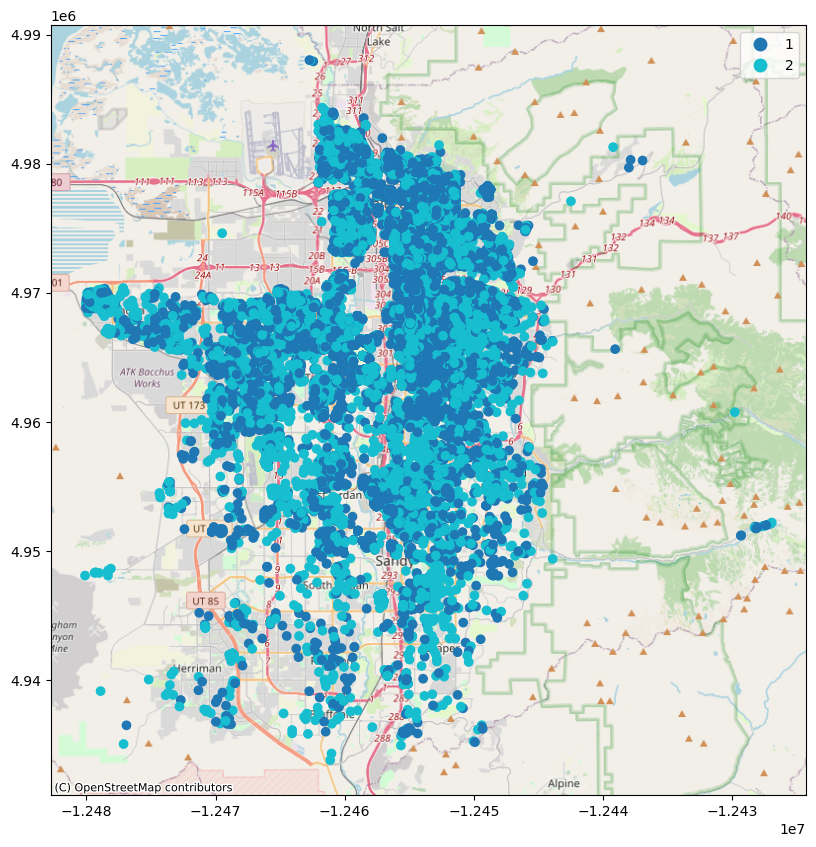

In [62]:
# visualize population by income and tenure status
lowincome_renters_gdf = hua_hui_gdf.loc[(hua_hui_gdf.hhinc < 3) &
                                    (hua_hui_gdf['ownershp'] == 2)].copy(deep=True)
map = viz.plot_gdf_map(lowincome_renters_gdf,column='hhinc', category=True)
map

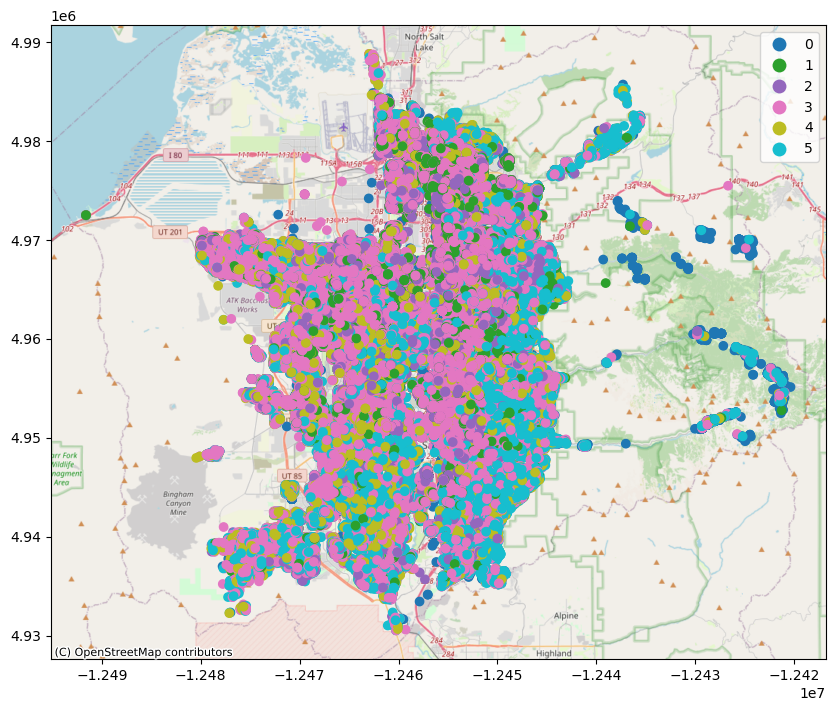

In [63]:
map = viz.plot_gdf_map(hua_hui_gdf,column='hhinc', category=True)
map

In [64]:
popdata = lowincome_renters_gdf[['y','x','numprec']].values.tolist()
map = Map(center=[center_y,center_x], zoom=11)

low_income_renters = Heatmap(
    locations = popdata,
    radius = 10, 
    max_val = 1000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'Low Income Renters',
)

map.add_layer(low_income_renters);
control = LayersControl(position='topright')
map.add_control(control)
map

Map(center=[40.65488164173781, -111.91217125889398], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [65]:
numprec_gdf = hua_hui_gdf.loc[(hua_hui_gdf.numprec >= 0)].copy(deep=True)
popdata = numprec_gdf[['y','x','numprec']].values.tolist()
map = Map(center=[center_y,center_x], zoom=11)

popmap = Heatmap(
    locations = popdata,
    radius = 10, 
    max_val = 10000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'Population Heat Map',
)

map.add_layer(popmap)
control = LayersControl(position='topright')
map.add_control(control)
map


Map(center=[40.65488164173781, -111.91217125889398], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [66]:
race1 = hua_hui_gdf.loc[(hua_hui_gdf.race == 1) & 
                    (hua_hui_gdf.hispan == 0) &
                    (hua_hui_gdf.hhinc == 5) &
                    (hua_hui_gdf.ownershp == 1) ].copy(deep=True)
# print how many people are in the race1 dataframe
print("map 1 has ",race1['numprec'].sum()," people")

popdata1 = race1[['y','x','numprec']].values.tolist()
race2 = hua_hui_gdf.loc[(hua_hui_gdf.race == 2) & 
                    (hua_hui_gdf.hispan == 0) &
                    (hua_hui_gdf.hhinc == 1) &
                    (hua_hui_gdf.ownershp == 2) ].copy(deep=True)
# print how many people are in the race1 dataframe
print("map 2 has ",race2['numprec'].sum()," people")
popdata2 = race2[['y','x','numprec']].values.tolist()

map = Map(center=[center_y,center_x], zoom=11)

popmap1 = Heatmap(
    locations = popdata1,
    radius = 10, 
    max_val = 10000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'White, High Income, Owner'
)

popmap2 = Heatmap(
    locations = popdata2,
    radius = 10, 
    max_val = 10000, 
    blur = 10, 
    gradient={0.2: 'green', 0.5: 'blue', 1.0: 'purple'},
    name = 'Black Low Income, Renter'
)

map.add_layer(popmap1)
map.add_layer(popmap2)
control = LayersControl(position='topright')
map.add_control(control)
map


map 1 has  184841  people
map 2 has  1508  people


Map(center=[40.65488164173781, -111.91217125889398], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [67]:
race1 = hua_hui_gdf.loc[(hua_hui_gdf.race == 1) & 
                    (hua_hui_gdf.hispan == 0) ].copy(deep=True)
# print how many people are in the race1 dataframe
print("map 1 has ",race1['numprec'].sum()," people")

popdata1 = race1[['y','x','numprec']].values.tolist()
race2 = hua_hui_gdf.loc[(hua_hui_gdf.race == 2) & 
                    (hua_hui_gdf.hispan == 0) ].copy(deep=True)
# print how many people are in the race1 dataframe
print("map 2 has ",race2['numprec'].sum()," people")
popdata2 = race2[['y','x','numprec']].values.tolist()

map = Map(center=[center_y,center_x], zoom=11)

popmap1 = Heatmap(
    locations = popdata1,
    radius = 10, 
    max_val = 10000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'White, Not Hispanic'
)

popmap2 = Heatmap(
    locations = popdata2,
    radius = 10, 
    max_val = 10000, 
    blur = 10, 
    gradient={0.2: 'green', 0.5: 'blue', 1.0: 'purple'},
    name = 'Black, Not Hispanic'
)

map.add_layer(popmap1)
map.add_layer(popmap2)
control = LayersControl(position='topright')
map.add_control(control)
map


map 1 has  765918  people
map 2 has  12160  people


Map(center=[40.65488164173781, -111.91217125889398], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [68]:
#racedot_map(hua_gdf,column='race', category=True)

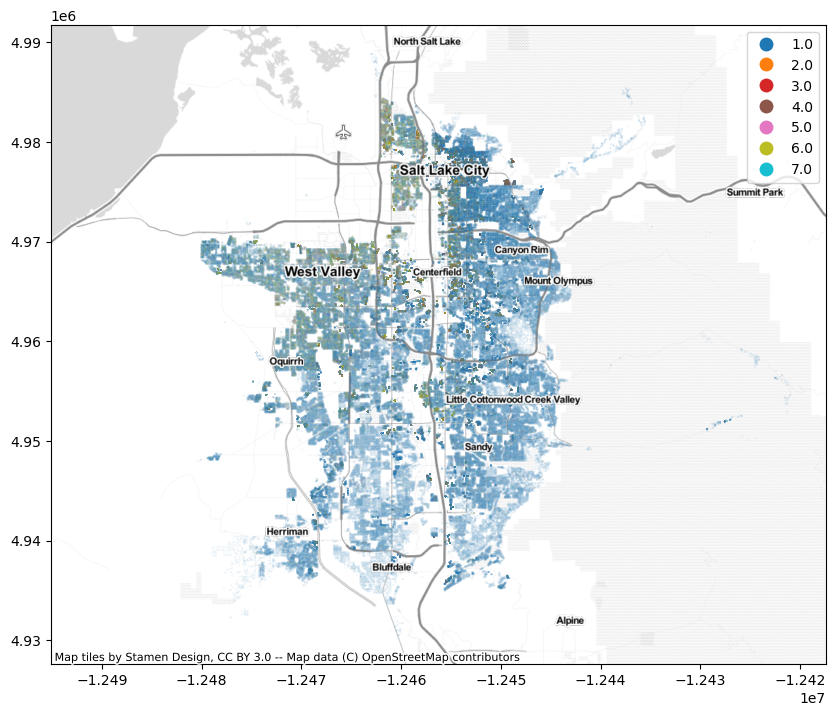

In [69]:
popdata = hua_hui_gdf.loc[(hua_hui_gdf.race >= 1)].copy(deep=True)
df_wm = popdata.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), column='race',
                      categorical=True, legend=True, markersize = 0.001)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

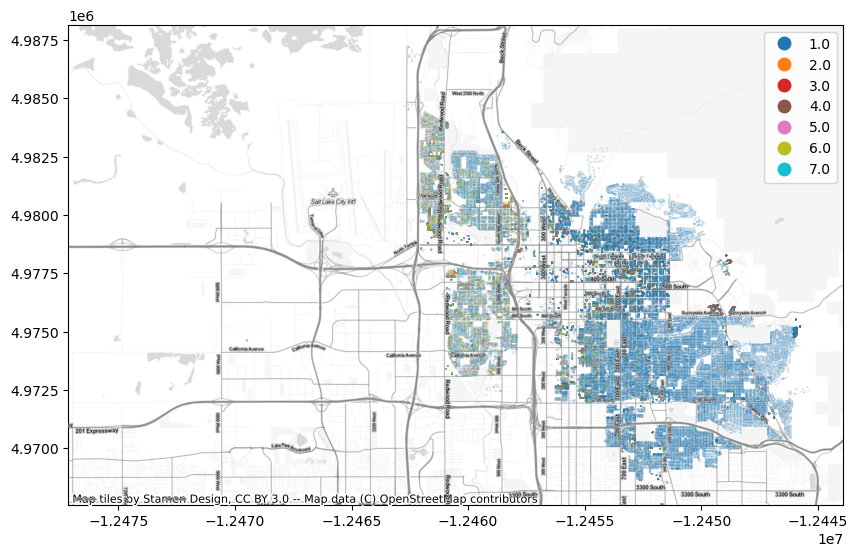

In [70]:
popdata = hua_hui_gdf.loc[(hua_hui_gdf.race >= 1) &
                       (hua_hui_gdf.placeNAME10 == "Salt Lake City") ].copy(deep=True)
df_wm = popdata.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), column='race',
                      categorical=True, legend=True, markersize = 0.01)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)